In [1]:
import os

if not os.path.exists('Output/'):
    raise Exception("Models not found, pls run 'Train' first.")

In [2]:
from keras.preprocessing.image import ImageDataGenerator

test_gen = ImageDataGenerator(rescale=1./255)

test_gen_output = test_gen.flow_from_directory('data_set/test', target_size=(256, 256), 
                                            batch_size=536, class_mode='binary')

2023-10-03 21:43:30.534587: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 536 images belonging to 2 classes.


In [3]:
x_test = []
y_test = []
for x, y in test_gen_output:
    x_test = x
    y_test = y
    break

# EvaluationVisualization

In [4]:
import matplotlib.pyplot as plt

In [5]:
from sklearn.metrics import ConfusionMatrixDisplay

def show_confusion_matrix(conf_matrix):
    ConfusionMatrixDisplay(conf_matrix, display_labels=['COVID','NORMAL']).plot()

# ModelEvaluateFunction

In [6]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

def evaluate(label, model):
    print('\n*****************',label, '*****************\n')
    model.summary()
    
    result = model.predict(x_test)
    
    y_pred = []
    for i in result.flatten():
        if i >= 0.5:
            y_pred.append(1) 
        else:
            y_pred.append(0) 
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    print('TP :', tp, ', TN :', tn,', FP :', fp,', FN :', fn)
    show_confusion_matrix(conf_matrix)
    
    accuracy = accuracy_score(y_test, y_pred)
    print('Accuracy :', accuracy)
    
    precision = precision_score(y_test, y_pred, average = "macro")
    print('Precision :', precision)
    
    recall = recall_score(y_test, y_pred, average = "macro")
    print('Recall :', recall)
    
    f1 = f1_score(y_test, y_pred, average = "macro")
    print('F1 score :', f1)

In [7]:
from tensorflow.keras.models import load_model


***************** Scratch model *****************

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 85, 85, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 42, 42, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1568)              0         
                                                                 
 den

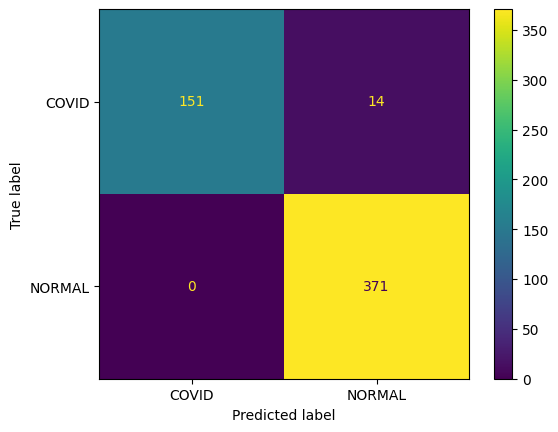

In [8]:
evaluate('Scratch model', load_model('Output/ScratchModel.h5'))


***************** Resnet model *****************

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 8, 8, 2048)        58331648  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 58,602,241
Trainable params: 58,458,497
Non-trainable par

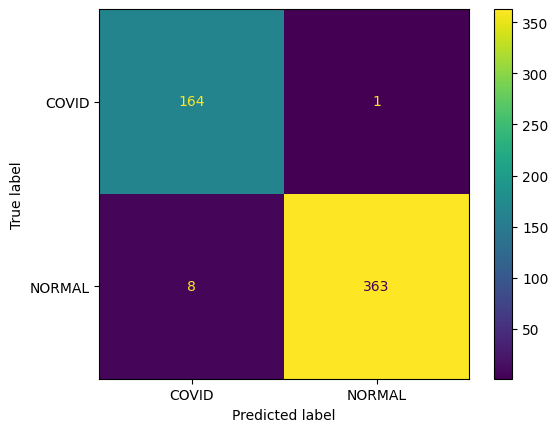

In [9]:
evaluate('Resnet model', load_model('Output/ResnetModel.h5'))


***************** Xception model *****************

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 21,132,073
Trainable params: 21,077,545
Non-trainable p

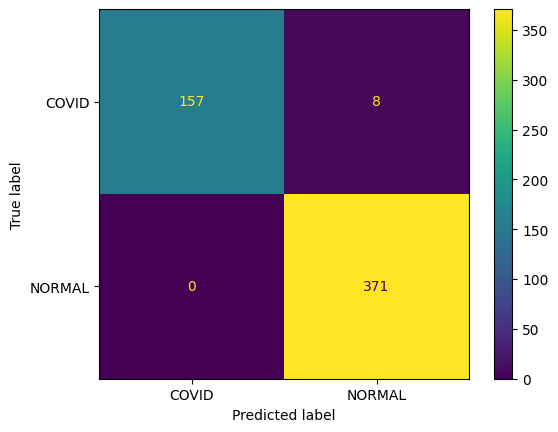

In [10]:
evaluate('Xception model', load_model('Output/XceptionModel.h5'))